Importing libraries

This notebook loads the data automatically from Kaggle using `kagglehub`.
You must have your Kaggle API token

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import os
from scipy.stats import chisquare




ModuleNotFoundError: No module named 'kagglehub'

In [ ]:
path = kagglehub.dataset_download("sobhanmoosavi/us-accidents")

csv_path = os.path.join(path, "US_Accidents_March23.csv")

df = pd.read_csv(csv_path)

100%|██████████| 653M/653M [00:11<00:00, 59.6MB/s] 

Extracting files...


The below code converts start and endtime to the to_datetime format, and confirms that all the times were parsed successfully.

In [ ]:
df["Start_Time"] = pd.to_datetime(df["Start_Time"], format="mixed", errors="coerce")
df["End_Time"] = pd.to_datetime(df["End_Time"], format="mixed", errors="coerce")

# print(df["Start_Time"].isna().sum())
# print(df["End_Time"].isna().sum())

# Merges the columns into one for general duration
df["Duration_Hours"] = (df["End_Time"] - df["Start_Time"]).dt.total_seconds() / 3600
print(df["Duration_Hours"].describe())

count    7.728394e+06
mean     7.407016e+00
std      2.252049e+02
min      2.027778e-02
25%      5.250000e-01
50%      1.247222e+00
75%      2.085833e+00
max      4.688232e+04
Name: Duration_Hours, dtype: float64


Converting the columns with numeric values from strings -> ints
Converting columns with true/false -> boolean

In [ ]:
numeric_cols = [
    "Temperature(F)", "Wind_Chill(F)", "Humidity(%)", "Pressure(in)",
    "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)", "Distance(mi)"
]

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")
df = df.dropna(subset=numeric_cols)
df[numeric_cols] = df[numeric_cols].astype(int)

binary_cols = [
    "Amenity", "Bump", "Crossing", "Give_Way", "Junction", "No_Exit",
    "Railway", "Roundabout", "Station", "Stop", "Traffic_Calming",
    "Traffic_Signal", "Turning_Loop"
]

df[binary_cols] = df[binary_cols].astype(bool)

Hypothesis 1

Hypothesis: Accidents occur more frequently in temperatures that are below freezing (Less than 32 degrees Fahrenheit) than temperatures that are above freezing (Greater than or equal to 32 degrees Fahrenheit).
Null: There is no differnce between accidents occuring in freezing and warmer temperatures.
Alternate: There is more frequent accidents in freezing temperatures than warmer temperatures.

Method: We grouped accidents by temperature into two categories: Freezing (< 32°F) and Warmer (≥ 32°F). We then used a Chi-Square Test to compare accident frequencies between the two groups, assuming equal likelihood under the null.

Temp_Class
Freezing (<32°F)     395944
Warmer (≥32°F)      4850867
Name: count, dtype: int64
Chi-square statistic: 3782552.67
P-value: 0.00000


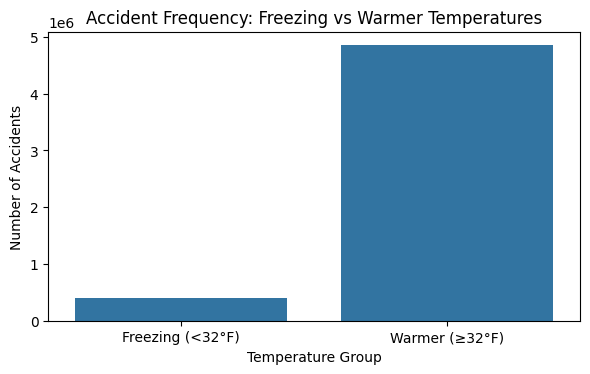

In [ ]:

df["Temp_Class"] = df["Temperature(F)"].apply(lambda x: "Freezing (<32°F)" if x < 32 else "Warmer (≥32°F)")
df_temp = df.dropna(subset=["Temp_Class"])
temp_accident_track = df_temp["Temp_Class"].value_counts().sort_index()
print(temp_accident_track)
observed = temp_accident_track.values
expected = [observed.sum() / 2] * 2

chi_stat, p_val = chisquare(f_obs=observed, f_exp=expected)
print(f"Chi-square statistic: {chi_stat:.2f}")
print(f"P-value: {p_val:.5f}")
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.barplot(x=temp_accident_track.index, y=temp_accident_track.values)
plt.title("Accident Frequency: Freezing vs Warmer Temperatures")
plt.xlabel("Temperature Group")
plt.ylabel("Number of Accidents")
plt.tight_layout()
plt.show()


Conclusion:
The chi-square test gave a high value with a p-value of 0, meaning the difference isn’t random, so we reject the null hypothesis. But even though we expected more accidents in freezing weather, the data shows that accidents actually happen more often in warmer conditions. So our original hypothesis wasn’t supported since accidents are more common when it’s warm.

Hypothesis 2:

Hypothesis: Higher Severity Accidents Have Longer Durations
Null: No difference in durations
Alternative: Severity 4 accidents have longer durations than Severity 1 Accidents

First we will prepare our data and get durations for severity 1 and 4

In [ ]:
df_valid = df[(df["Duration_Hours"] > 0) & (df["Duration_Hours"] < 24)]
df_valid = df_valid.dropna(subset=["Severity", "Duration_Hours"])

sev_1 = df_valid[df_valid["Severity"] == 1]["Duration_Hours"]
sev_4 = df_valid[df_valid["Severity"] == 4]["Duration_Hours"]


Next, we will use a Two-Sample t-test (Welch's)

In [ ]:
from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind(sev_4, sev_1, equal_var=False)
print(f"T-statistic: {t_stat:.2f}")
print(f"P-value: {p_val:.5f}")


T-statistic: 226.00
P-value: 0.00000


Now  we will print our results and show our visualization

Average duration (Severity 1): 0.7646325379628887
Average duration (Severity 4): 2.330546917922092


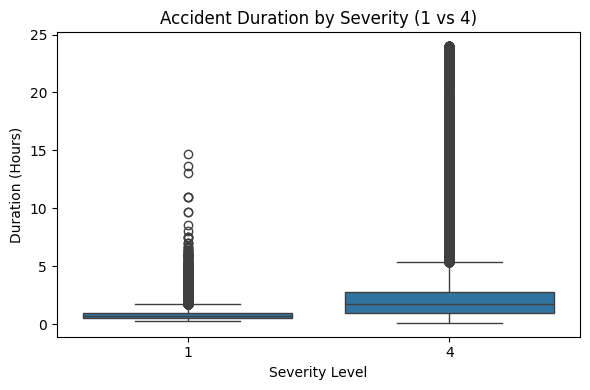

In [ ]:
print("Average duration (Severity 1):", sev_1.mean())
print("Average duration (Severity 4):", sev_4.mean())

plt.figure(figsize=(6, 4))
sns.boxplot(data=df_valid[df_valid["Severity"].isin([1, 4])], x="Severity", y="Duration_Hours")
plt.title("Accident Duration by Severity (1 vs 4)")
plt.xlabel("Severity Level")
plt.ylabel("Duration (Hours)")
plt.tight_layout()
plt.show()


Conclusion: The Welch’s t-test returned a p-value of 0, allowing us to reject the null hypothesis. The data shows that Severity 4 accidents have significantly longer durations than Severity 1. This is also visually supported by the boxplot, where Severity 4 has a higher median and a wider spread of values where many last several hours longer than the most common Severity 1 accidents.

Hypothesis 3

Hypothesis: Certain roadway features are present more frequently at accident locations than others.
Null: All roadway features are equally likely to be present at accident sites; there is no difference in their frequencies. 
Alternate: Some roadway features are significantly more common at accident sites than others.

Method: We'll analyze the 13 different roadways present in the dataset, and calculate the proportion of accidents that occured near each feature. I'll be using a chi-squared test to see if the data shows that the features appear in accidents equally. 

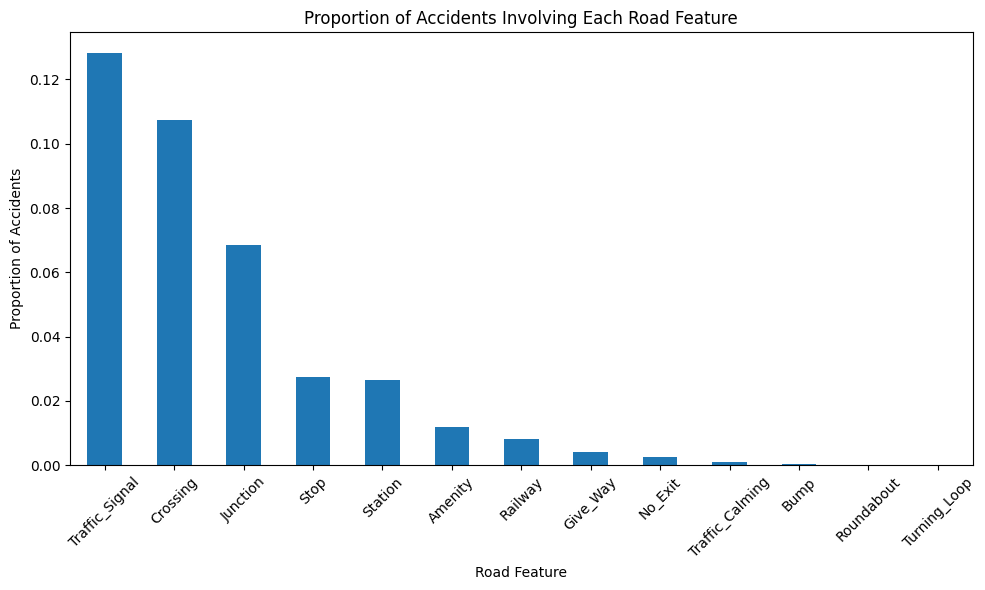

Chi-square statistic: 4029563.90
P-value: 0.00000


In [ ]:

binary_cols = [
    "Amenity", "Bump", "Crossing", "Give_Way", "Junction", "No_Exit",
    "Railway", "Roundabout", "Station", "Stop", "Traffic_Calming",
    "Traffic_Signal", "Turning_Loop"
]

road_feature_proportions = df[binary_cols].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
road_feature_proportions.plot(kind="bar")
plt.title("Proportion of Accidents Involving Each Road Feature")
plt.ylabel("Proportion of Accidents")
plt.xlabel("Road Feature")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

observed = road_feature_proportions.values * len(df)
expected = [observed.mean()] * len(observed)

chi_stat, p_val = chisquare(f_obs=observed, f_exp=expected)
print(f"Chi-square statistic: {chi_stat:.2f}")
print(f"P-value: {p_val:.5f}")

Conclusion: We calculated a P value of 0, which let's us reject the null hypothesis. Traffic signals, crossings, and junctions had the largest proportion of accidents near them, suggesting that these features have an elevated risk of an accident likely because of the complexity of navinavigatingagting these spaces compared to other roadway features.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

df_model = df.dropna(subset=["Severity"])
df_model = df_model[df_model["Severity"].isin([1, 2, 3, 4])]

feature_cols = numeric_cols + binary_cols
X = df_model[feature_cols]
y = (df_model["Severity"] >= 3).astype(int)  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_trans = scaler.fit_transform(X_train)
X_test_trans = scaler.transform(X_test)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_trans, y_train)

y_pred = model.predict(X_test_trans)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Not Severe", "Severe"],
            yticklabels=["Not Severe", "Severe"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Used Seaborn)")
plt.tight_layout()
plt.show()


So what above is this code is doing is that it is checking data for accidents of severity levels which is 3 or higher.